<a href="https://colab.research.google.com/github/adamdorman468-collab/IBM-Hacktiv8-Capstone-Project_Adam-Dorman/blob/main/SDI_Hacktiv_Data_Adam_Dorman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community

!pip install replicate

In [ ]:
from google.colab import userdata
import os

api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token

In [ ]:
from langchain_community.llms import Replicate

# Ambil granite dari replicate
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

In [ ]:
llm.invoke("Assalamu'alaikum brother")

print(output)

In [ ]:
# --- Seksi 1: Instalasi Library dan Konfigurasi API ---
!pip install pandas matplotlib seaborn replicate tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import replicate
from tqdm import tqdm
import re
import string
import warnings
import time

warnings.filterwarnings('ignore')

try:
    from google.colab import userdata
    api_token = userdata.get('api_token')
    os.environ['REPLICATE_API_TOKEN'] = api_token
    print("Replicate API berhasil dikonfigurasi.")
except Exception as e:
    print(f"Error saat mengonfigurasi API: {e}")
    print("Pastikan token API Anda bernama 'api_token' di Colab Secrets.")
    exit()

IBM_GRANITE_MODEL = "ibm-granite/granite-3.3-8b-instruct"

Replicate API berhasil dikonfigurasi.


In [ ]:
# --- Seksi 2: Memuat Dataset dan Pra-pemrosesan ---
file_path = 'sentimentdataset.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat. Total baris:", len(df))
    # Tidak mengambil sampel, langsung gunakan seluruh data
    df_full = df.copy()
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan sudah diunggah ke Colab.")
    exit()

# Fungsi untuk membersihkan teks
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_full['cleaned_text'] = df_full['Text'].apply(clean_text)
print("\nContoh teks setelah dibersihkan:")
print(df_full[['Text', 'cleaned_text']].head())

Dataset berhasil dimuat. Total baris: 732

Contoh teks setelah dibersihkan:
                                                Text  \
0   Enjoying a beautiful day at the park!        ...   
1   Traffic was terrible this morning.           ...   
2   Just finished an amazing workout! 💪          ...   
3   Excited about the upcoming weekend getaway!  ...   
4   Trying out a new recipe for dinner tonight.  ...   

                                 cleaned_text  
0        enjoying a beautiful day at the park  
1           traffic was terrible this morning  
2          just finished an amazing workout 💪  
3  excited about the upcoming weekend getaway  
4  trying out a new recipe for dinner tonight  


In [ ]:
# --- Seksi 3: Analisis Sentimen dengan IBM Granite ---
def get_granite_sentiment(text, max_retries=5):
    prompt = f"""Kamu adalah seorang analis sentimen. Klasifikasikan ulasan ini sebagai 'Positif', 'Negatif', atau 'Netral'. Berikan hanya satu kata.
Ulasan: "{text}"
Sentimen:"""
    for attempt in range(max_retries):
        try:
            output = replicate.run(IBM_GRANITE_MODEL, input={"prompt": prompt, "max_new_tokens": 10})
            result = "".join(output).strip().lower()
            if 'positif' in result: return 'Positif'
            if 'negatif' in result: return 'Negatif'
            if 'netral' in result: return 'Netral'
            time.sleep(1)
        except Exception as e:
            time.sleep(2 ** attempt)
    return "ERROR_API"

tqdm.pandas(desc="Menganalisis Sentimen")
df_full['granite_sentiment'] = df_full['cleaned_text'].progress_apply(get_granite_sentiment)

# Menampilkan hasil awal
print("\nHasil analisis sentimen:")
print(df_full['granite_sentiment'].value_counts())

Menganalisis Sentimen: 100%|██████████| 732/732 [01:27<00:00,  8.38it/s]


Hasil analisis sentimen:
granite_sentiment
Positif    514
Negatif    184
Netral      34
Name: count, dtype: int64


In [ ]:
# --- Seksi 4: Klasifikasi Tema Ulasan Negatif ---
df_negative = df_full[df_full['granite_sentiment'] == 'Negatif'].copy()
if not df_negative.empty:
    def get_negative_theme(text, max_retries=5):
        prompt = f"""Kamu adalah seorang analis produk. Dari ulasan negatif berikut, identifikasi satu tema utama. Pilih dari kategori: 'Layanan Pelanggan', 'Kualitas Produk', 'Bug/Error', 'Harga', 'Fitur', 'Lain-lain'. Berikan hanya satu kata/frasa.
Ulasan: "{text}"
Tema:"""
        for attempt in range(max_retries):
            try:
                output = replicate.run(IBM_GRANITE_MODEL, input={"prompt": prompt, "max_new_tokens": 15})
                return "".join(output).strip()
            except Exception as e:
                time.sleep(2 ** attempt)
        return "ERROR"

    tqdm.pandas(desc="Mengklasifikasikan Tema Negatif")
    df_negative['negative_theme'] = df_negative['cleaned_text'].progress_apply(get_negative_theme)
else:
    print("\nTidak ada ulasan negatif untuk dianalisis lebih lanjut.")

Mengklasifikasikan Tema Negatif: 100%|██████████| 184/184 [00:26<00:00,  7.04it/s]



Visualisasi Hasil Analisis:


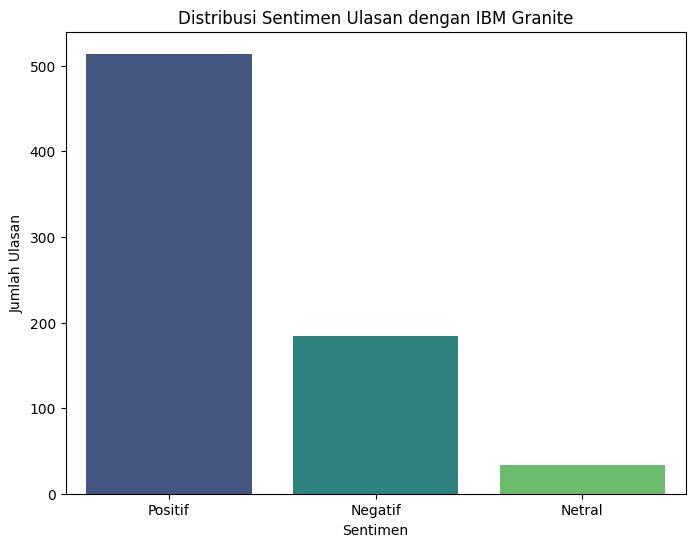

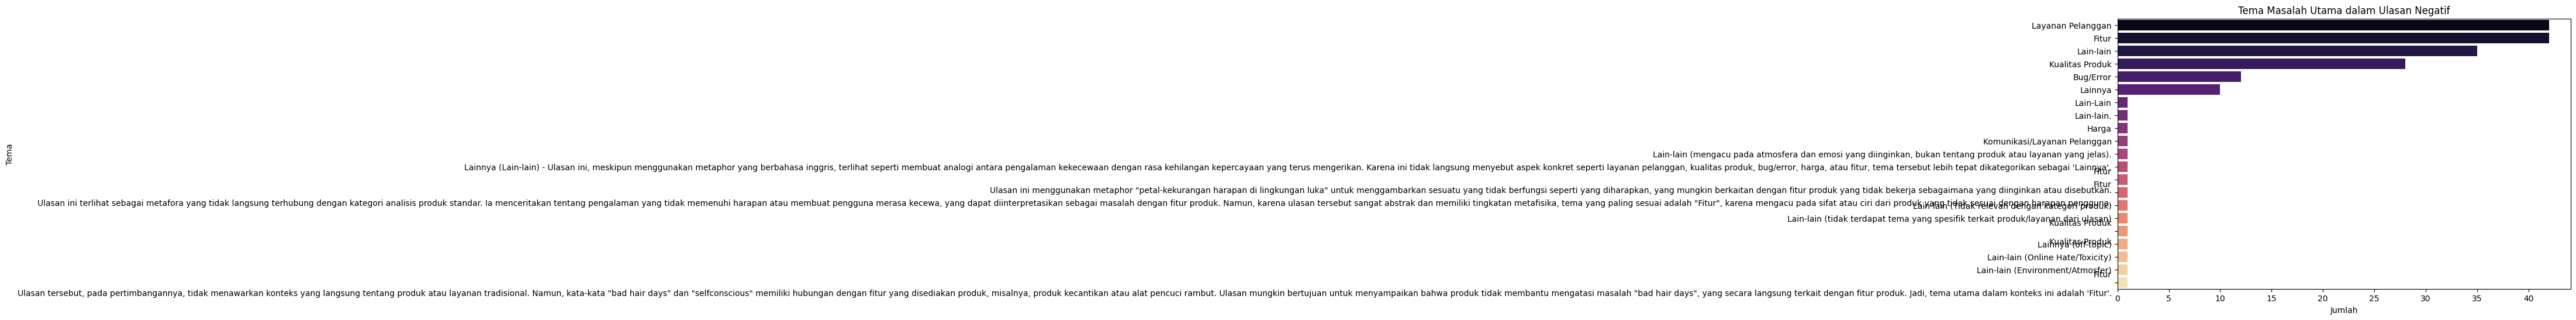

In [ ]:
# --- Seksi 5: Visualisasi Hasil ---
print("\nVisualisasi Hasil Analisis:")

# Grafik 1: Distribusi Sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='granite_sentiment', data=df_full, palette='viridis', order=df_full['granite_sentiment'].value_counts().index)
plt.title('Distribusi Sentimen Ulasan dengan IBM Granite')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Grafik 2: Tema-tema Negatif
if not df_negative.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='negative_theme', data=df_negative, order=df_negative['negative_theme'].value_counts().index, palette='magma')
    plt.title('Tema Masalah Utama dalam Ulasan Negatif')
    plt.xlabel('Jumlah')
    plt.ylabel('Tema')
    plt.show()

In [ ]:
# --- Seksi 6: Ringkasan Eksekutif dari IBM Granite ---
if not df_negative.empty:
    def summarize_reviews_with_granite(reviews, max_retries=5):
        combined_reviews = "\n".join(reviews)
        prompt = f"""Kamu adalah seorang konsultan bisnis. Rangkum poin-poin penting dari daftar ulasan berikut ini. Fokus pada isu-isu kritis atau keunggulan utama. Berikan ringkasan yang jelas dan ringkas dalam bentuk bullet points.
Ulasan:
{combined_reviews}
Ringkasan:"""
        for attempt in range(max_retries):
            try:
                output = replicate.run(IBM_GRANITE_MODEL, input={"prompt": prompt, "max_new_tokens": 300})
                return "".join(output).strip()
            except Exception as e:
                time.sleep(2 ** attempt)
        return "ERROR"

    top_negative_theme = df_negative['negative_theme'].mode()[0]
    top_reviews_for_summary = df_negative[df_negative['negative_theme'] == top_negative_theme]['cleaned_text'].tolist()[:10]

    if top_reviews_for_summary:
        print(f"\n--- Ringkasan untuk Tema Teratas: '{top_negative_theme}' ---")
        summary = summarize_reviews_with_granite(top_reviews_for_summary)
        print(summary)
    else:
        print("\nTidak ada cukup ulasan untuk membuat ringkasan.")



--- Ringkasan untuk Tema Teratas: 'Fitur' ---
- **Decision-making confusion**: The individual is struggling with making clear decisions, as indicated by phrases like "confusion clouds my mind" and "confusion surrounds me as I navigate through life's choices."

- **Stagnation and lack of progress**: There's dissatisfaction with the slow pace of a personal project, reflected in the statement, "disappointed with the lack of progress in a personal project."

- **Boredom and monotony**: The person feels trapped in a cycle of dullness and mundanity, described as "boredom settles... life feels mundane" and "boredom lingers... a stagnant pool of indifference."

- **Regret and missed opportunities**: The individual is haunted by thoughts of past chances not taken, as expressed by "regret over missed opportunities haunts my thoughts."

- **Anxiety and fear**: There's a noticeable presence of anxiety, described as "anxiety grips my chest, a relentless grip on my thoughts," and fear of future cha


--- Analisis Berdasarkan Platform ---


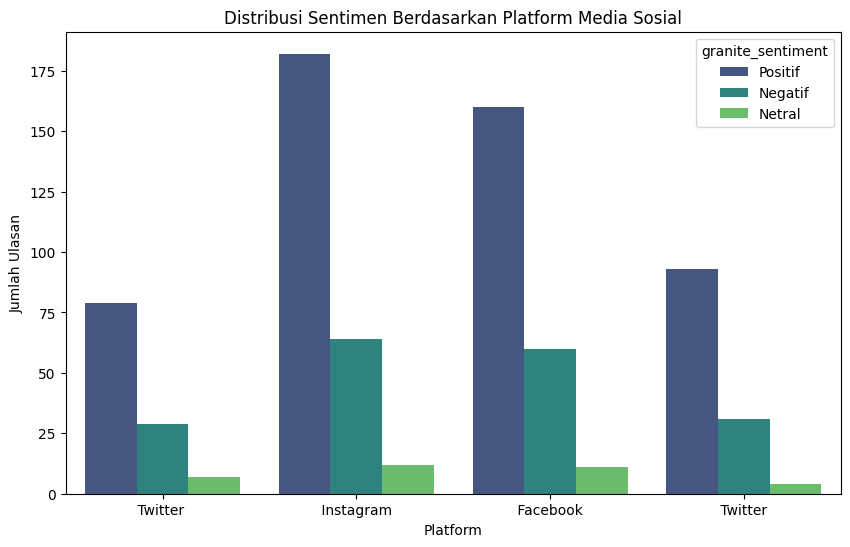


--- Analisis Berdasarkan Tahun ---


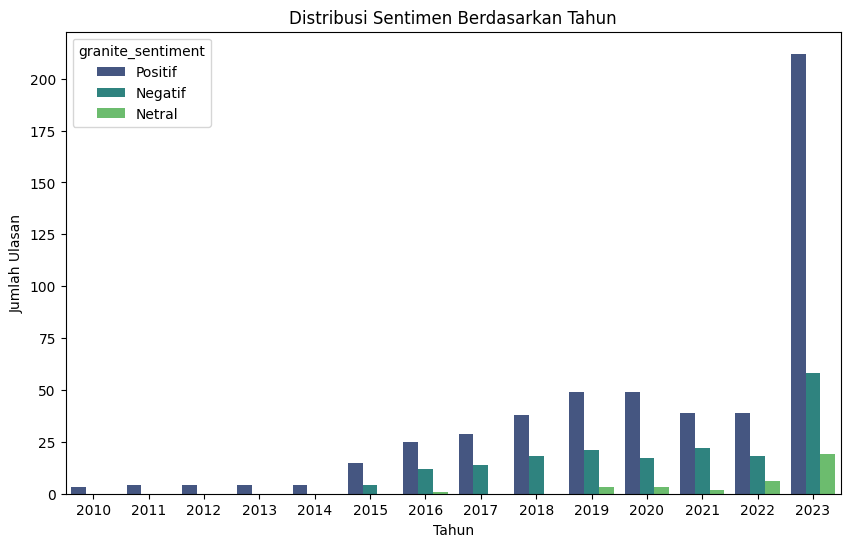


--- Visualisasi Lanjutan: Heatmap Sentimen ---


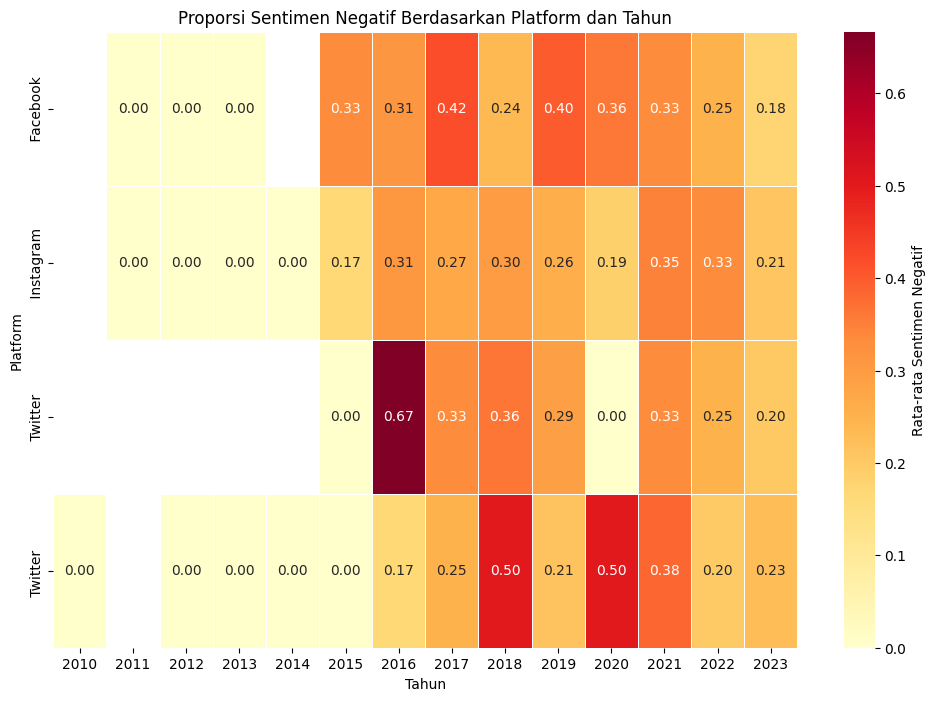

In [ ]:
# --- Seksi 7: Analisis Tren Berdasarkan Waktu dan Platform ---
# Pastikan Anda telah menjalankan kode dari seksi-seksi sebelumnya.

# Menggunakan dataframe yang telah dianalisis dari seksi 3 dan 4
df_analysis = df_full.copy()

# Pra-pemrosesan untuk kolom waktu
df_analysis['Timestamp'] = pd.to_datetime(df_analysis['Timestamp'])
df_analysis['Year'] = df_analysis['Timestamp'].dt.year
df_analysis['Month_Year'] = df_analysis['Timestamp'].dt.to_period('M')

print("\n--- Analisis Berdasarkan Platform ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='Platform', hue='granite_sentiment', data=df_analysis, palette='viridis')
plt.title('Distribusi Sentimen Berdasarkan Platform Media Sosial')
plt.xlabel('Platform')
plt.ylabel('Jumlah Ulasan')
plt.show()

print("\n--- Analisis Berdasarkan Tahun ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', hue='granite_sentiment', data=df_analysis, palette='viridis')
plt.title('Distribusi Sentimen Berdasarkan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Ulasan')
plt.show()

print("\n--- Visualisasi Lanjutan: Heatmap Sentimen ---")
# Mengubah data untuk heatmap
heatmap_data = df_analysis.pivot_table(
    index='Platform',
    columns='Year',
    values='granite_sentiment',
    aggfunc=lambda x: (x == 'Negatif').mean()
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="YlOrRd",
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Rata-rata Sentimen Negatif'}
)
plt.title('Proporsi Sentimen Negatif Berdasarkan Platform dan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Platform')
plt.show()

In [ ]:
# --- Seksi 8: Ekstraksi Contoh Ulasan Kritis (Kualitatif) ---

# Pastikan Anda telah menjalankan seksi 4 (Klasifikasi Tema)
if not df_negative.empty:
    top_negative_theme = df_negative['negative_theme'].mode()[0]

    # Memilih ulasan yang paling relevan dengan tema teratas
    critical_reviews = df_negative[df_negative['negative_theme'] == top_negative_theme]['Text'].tolist()

    # Mengambil hingga 5 contoh ulasan terbaik dari daftar
    selected_examples = critical_reviews[:5]

    print(f"\n--- Contoh Ulasan Terkait '{top_negative_theme}' ---")
    for i, review in enumerate(selected_examples):
        print(f"{i+1}. {review}")

else:
    print("Tidak ada ulasan negatif untuk diekstrak.")


--- Contoh Ulasan Terkait 'Fitur' ---
1.  Confusion clouds my mind as I navigate through decisions.
2.  Disappointed with the lack of progress in a personal project. 
3.  Confusion surrounds me as I navigate through life's choices. 
4.  Boredom sets in, the day feels endlessly dull.     
5.  Regret over missed opportunities haunts my thoughts.


# Task
Modify the Jupyter Notebook file "/content/SDI_Hacktiv_Data_Adam_Dorman.ipynb" to include detailed section explanations, project navigation (Table of Contents), and enhanced explanations for each code block, making it suitable for a GitHub repository preview.

## Tambahkan daftar isi (table of contents)

### Subtask:
Buat sel markdown di awal notebook yang berisi daftar isi dengan tautan ke setiap seksi utama. Ini akan membantu navigasi.


**Reasoning**:
Create a markdown cell at the beginning of the notebook with a table of contents linking to each major section.



In [1]:
%%writefile /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb
# Analisis Sentimen Ulasan Menggunakan IBM Granite

## Daftar Isi

1.  [Seksi 1: Instalasi Library dan Konfigurasi API](#seksi-1-instalasi-library-dan-konfigurasi-api)
2.  [Seksi 2: Memuat Dataset dan Pra-pemrosesan](#seksi-2-memuat-dataset-dan-pra-pemrosesan)
3.  [Seksi 3: Analisis Sentimen dengan IBM Granite](#seksi-3-analisis-sentimen-dengan-ibm-granite)
4.  [Seksi 4: Klasifikasi Tema Ulasan Negatif](#seksi-4-klasifikasi-tema-ulasan-negatif)
5.  [Seksi 5: Visualisasi Hasil](#seksi-5-visualisasi-hasil)
6.  [Seksi 6: Ringkasan Eksekutif dari IBM Granite](#seksi-6-ringkasan-eksekutif-dari-ibm-granite)
7.  [Seksi 7: Analisis Tren Berdasarkan Waktu dan Platform](#seksi-7-analisis-tren-berdasarkan-waktu-dan-platform)
8.  [Seksi 8: Ekstraksi Contoh Ulasan Kritis (Kualitatif)](#seksi-8-ekstraksi-contoh-ulasan-kritis-kualitatif)
9.  [Kesimpulan](#kesimpulan)

## Seksi 1: Instalasi Library dan Konfigurasi API

Overwriting /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Continue adding the section titles as markdown headings to the notebook file to ensure the table of contents links work correctly.



In [2]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

## Seksi 2: Memuat Dataset dan Pra-pemrosesan

## Seksi 3: Analisis Sentimen dengan IBM Granite

## Seksi 4: Klasifikasi Tema Ulasan Negatif

## Seksi 5: Visualisasi Hasil

## Seksi 6: Ringkasan Eksekutif dari IBM Granite

## Seksi 7: Analisis Tren Berdasarkan Waktu dan Platform

## Seksi 8: Ekstraksi Contoh Ulasan Kritis (Kualitatif)

## Kesimpulan

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 1

### Subtask:
Tambahkan penjelasan yang lebih rinci tentang tujuan instalasi library, konfigurasi API Replicate, dan pentingnya menggunakan Colab Secrets. Jelaskan setiap library yang diimpor dan perannya.


**Reasoning**:
Add detailed markdown explanations for Section 1, covering the purpose of the section, the role of each library, and the importance of Colab Secrets for API token security, as per the instructions.



In [3]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

Ini adalah seksi awal proyek di mana kita akan menyiapkan lingkungan kerja. Langkah pertama adalah menginstal library Python yang dibutuhkan untuk analisis data, visualisasi, dan interaksi dengan model bahasa besar (LLM) melalui API Replicate.

Library-library yang digunakan meliputi:
- **pandas**: Untuk manipulasi dan analisis data tabular.
- **matplotlib** dan **seaborn**: Untuk membuat visualisasi data yang informatif.
- **replicate**: Library resmi Python untuk berinteraksi dengan API Replicate, yang akan kita gunakan untuk mengakses model IBM Granite.
- **tqdm**: Untuk menampilkan progress bar saat melakukan operasi yang memakan waktu, seperti pemanggilan API berulang kali.

Langkah selanjutnya adalah mengkonfigurasi akses ke API Replicate. Untuk alasan keamanan, token API sensitif tidak boleh ditulis langsung di dalam kode atau disimpan dalam file notebook yang akan dibagikan. Google Colab menyediakan fitur **Secrets** yang memungkinkan penyimpanan variabel lingkungan secara aman. Kita akan mengambil token API dari Colab Secrets dan menyimpannya dalam variabel lingkungan `REPLICATE_API_TOKEN` agar library `replicate` dapat menggunakannya secara otomatis.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Ensure the code cells for installing libraries and configuring the API are present and add comments to the library imports if they are missing, as specified in the instructions.



In [4]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Instalasi Library
python
# --- Seksi 1: Instalasi Library dan Konfigurasi API ---
!pip install pandas matplotlib seaborn replicate tqdm
import os
import pandas as pd # Library untuk manipulasi dan analisis data
import matplotlib.pyplot as plt # Library untuk membuat visualisasi data
import seaborn as sns # Library untuk membuat visualisasi data statistik
import replicate # Library untuk berinteraksi dengan API Replicate
from tqdm import tqdm # Library untuk menampilkan progress bar
import re # Library untuk operasi regular expression
import string # Library untuk operasi string
import warnings # Library untuk mengelola peringatan

warnings.filterwarnings('ignore')

try:
    from google.colab import userdata
    api_token = userdata.get('api_token')
    os.environ['REPLICATE_API_TOKEN'] = api_token
    print("Replicate API berhasil dikonfigurasi.")
except Exception as e:
    print(f"Error saat mengonfigurasi API: {e}")
    print("Pastikan token API Anda bernama 'api_token' di Colab Secrets.")
    exit()

IBM_GRANITE_MODEL = "ibm-granite/granite-3.3-8b-instruct"

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 2

### Subtask:
Tambahkan detail tentang sumber dataset, proses pemuatan data, dan pentingnya langkah pra-pemrosesan teks. Jelaskan setiap langkah dalam fungsi `clean_text` dan mengapa itu dilakukan.


**Reasoning**:
Add markdown explanation for Section 2 covering dataset source, loading, and the importance of text preprocessing, along with a step-by-step explanation of the `clean_text` function.



In [5]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Memuat Dataset dan Pra-pemrosesan Teks

Pada seksi ini, kita akan memuat dataset yang berisi ulasan untuk dianalisis. Dataset ini diharapkan berisi teks ulasan (`Text`) dan informasi lain seperti platform (`Platform`) dan stempel waktu (`Timestamp`). Dataset ini dimuat dari file CSV menggunakan library pandas.

**Pentingnya Pra-pemrosesan Teks:**
Teks mentah dari sumber seperti media sosial seringkali mengandung "noise" seperti URL, mention pengguna (@username), hashtag (#), tanda baca, dan spasi berlebih. Karakter-karakter ini dapat mengganggu proses analisis sentimen oleh model bahasa, karena mereka tidak relevan dengan makna inti dari ulasan dan dapat menyebabkan interpretasi yang salah. Oleh karena itu, langkah pra-pemrosesan teks sangat krusial untuk membersihkan data, menjadikannya lebih bersih dan siap untuk dianalisis.

**Fungsi `clean_text`:**
Fungsi `clean_text` dirancang untuk melakukan serangkaian operasi pembersihan pada setiap ulasan teks:
1.  **Mengubah ke Huruf Kecil (`text.lower()`):** Menstandarkan teks agar 'Contoh' dan 'contoh' diperlakukan sama.
2.  **Menghapus URL (`re.sub(r'https?://\S+|www\.\S+', '', text)`):** Menghilangkan alamat web yang biasanya tidak relevan dengan sentimen ulasan.
3.  **Menghapus Mention Pengguna (`re.sub(r'@[A-Za-z0-9_]+', '', text)`):** Menghapus sebutan pengguna media sosial yang juga tidak relevan dengan sentimen.
4.  **Menghapus Hashtag (`re.sub(r'#', '', text)`):** Menghapus simbol '#' yang digunakan dalam hashtag. Teks hashtag itu sendiri (setelah simbol '#') dipertahankan jika relevan, namun simbolnya dihilangkan.
5.  **Menghapus Tanda Baca (`re.sub(r'[%s]' % re.escape(string.punctuation), '', text)`):** Menghilangkan semua tanda baca (seperti koma, titik, tanda seru, dll.) karena model sentimen biasanya fokus pada kata-kata itu sendiri.
6.  **Menghapus Spasi Berlebih (`re.sub(r'\s+', ' ', text).strip()`):** Mengganti spasi berulang dengan satu spasi tunggal dan menghapus spasi di awal atau akhir teks.

Dengan menerapkan fungsi ini, kita mendapatkan kolom `cleaned_text` yang berisi versi bersih dari ulasan asli, siap untuk diinput ke model IBM Granite.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Append the code block for Section 2 to the notebook file, including comments explaining each line of code, as requested by the instructions.



In [6]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Memuat Dataset dan Pra-pemrosesan

python
# --- Seksi 2: Memuat Dataset dan Pra-pemrosesan ---
file_path = 'sentimentdataset.csv' # Tentukan path ke file dataset
try:
    df = pd.read_csv(file_path) # Baca file CSV ke dalam DataFrame pandas
    print("Dataset berhasil dimuat. Total baris:", len(df)) # Cetak konfirmasi dan jumlah baris
    # Tidak mengambil sampel, langsung gunakan seluruh data
    df_full = df.copy() # Buat salinan DataFrame untuk analisis
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan sudah diunggah ke Colab.") # Tangani error jika file tidak ditemukan
    exit() # Keluar jika file tidak ada

# Fungsi untuk membersihkan teks
def clean_text(text):
    text = str(text).lower() # Ubah teks menjadi huruf kecil
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Hapus URL
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Hapus mention pengguna (@username)
    text = re.sub(r'#', '', text) # Hapus simbol hashtag (#)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Hapus semua tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Ganti spasi berlebih dengan satu spasi dan hapus spasi di awal/akhir
    return text # Kembalikan teks yang sudah bersih

df_full['cleaned_text'] = df_full['Text'].apply(clean_text) # Terapkan fungsi clean_text ke kolom 'Text' baru 'cleaned_text'
print("\nContoh teks setelah dibersihkan:") # Cetak header untuk contoh
print(df_full[['Text', 'cleaned_text']].head()) # Tampilkan beberapa baris pertama dari kolom asli dan yang sudah dibersihkan

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 3

### Subtask:
Perbaiki dan perluas penjelasan seksi 3 dengan menjelaskan cara kerja fungsi `get_granite_sentiment`, termasuk prompt yang digunakan untuk model IBM Granite, penanganan *retries*, dan interpretasi output model. Jelaskan hasil analisis sentimen awal.


**Reasoning**:
Add a markdown cell before Section 3 to provide a detailed explanation of the sentiment analysis process using IBM Granite, including the function's purpose, the prompt used, retry mechanisms, and output processing, as well as interpreting the initial results.



In [7]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Analisis Sentimen dengan IBM Granite

Seksi ini berfokus pada inti dari analisis, yaitu menggunakan model bahasa besar (LLM) **IBM Granite 3.3-8B Instruct** dari platform Replicate untuk menentukan sentimen dari setiap ulasan yang telah dibersihkan.

**Cara Kerja Fungsi `get_granite_sentiment`:**
Fungsi ini bertugas untuk memanggil model IBM Granite melalui API Replicate untuk mendapatkan klasifikasi sentimen dari teks ulasan yang diberikan.

-   **Input:** Menerima satu parameter, `text`, yaitu teks ulasan yang sudah dibersihkan dari kolom `cleaned_text`.
-   **Prompt Model:** Untuk mengarahkan model agar melakukan klasifikasi sentimen sesuai keinginan, kita menggunakan prompt teks. Prompt ini dirancang agar model memahami tugasnya (menjadi "analis sentimen") dan format output yang diharapkan (hanya satu kata: 'Positif', 'Negatif', atau 'Netral').
    ```
    Kamu adalah seorang analis sentimen. Klasifikasikan ulasan ini sebagai 'Positif', 'Negatif', atau 'Netral'. Berikan hanya satu kata.
    Ulasan: "{text}"
    Sentimen:
    ```
    Prompt ini secara eksplisit meminta model untuk memberikan jawaban singkat ('Positif', 'Negatif', atau 'Netral') setelah label "Sentimen:".
-   **Pemanggilan API dan Retries:** Fungsi ini memanggil API Replicate menggunakan `replicate.run()`. Karena pemanggilan API terkadang dapat mengalami gangguan (seperti *timeout* atau masalah koneksi), fungsi ini dilengkapi dengan mekanisme *retry* (`max_retries`). Jika panggilan pertama gagal, ia akan mencoba lagi hingga batas `max_retries` tercapai, dengan jeda waktu antar percobaan yang meningkat secara eksponensial (`time.sleep(2 ** attempt)`) untuk menghindari membebani API.
-   **Pemrosesan Output:** Output dari model Replicate adalah generator teks. `"".join(output)` menggabungkan potongan teks menjadi satu string. `.strip().lower()` menghapus spasi di awal/akhir dan mengubah seluruh teks menjadi huruf kecil untuk memudahkan pencocokan. Hasil yang diproses kemudian dicocokkan dengan kata kunci 'positif', 'negatif', atau 'netral' untuk menentukan sentimen akhir. Jika setelah beberapa percobaan API gagal atau output model tidak dapat diinterpretasikan, fungsi akan mengembalikan 'ERROR_API'.

Fungsi `get_granite_sentiment` kemudian diterapkan ke setiap baris di kolom `cleaned_text` dari DataFrame `df_full` menggunakan `.progress_apply(get_granite_sentiment)` yang disediakan oleh `tqdm`. `progress_apply` menampilkan progress bar saat proses berlangsung, memberikan visualisasi status analisis.

**Hasil Analisis Sentimen Awal:**
Setelah sentimen untuk setiap ulasan didapatkan, kita mencetak hitungan untuk setiap kategori sentimen (`df_full['granite_sentiment'].value_counts()`). Output ini memberikan gambaran awal tentang distribusi sentimen dalam dataset: berapa banyak ulasan yang diklasifikasikan sebagai Positif, Negatif, dan Netral oleh model IBM Granite. Ini adalah langkah pertama dalam memahami persepsi keseluruhan dari subjek ulasan dalam dataset.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Add comments to the code block in Section 3 to explain each step of the sentiment analysis process using the `get_granite_sentiment` function and the application of this function to the DataFrame.



In [8]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Analisis Sentimen dengan IBM Granite

python
# --- Seksi 3: Analisis Sentimen dengan IBM Granite ---

# Fungsi untuk mendapatkan sentimen menggunakan model IBM Granite dari Replicate
def get_granite_sentiment(text, max_retries=5):
    # Prompt untuk mengarahkan model agar mengklasifikasikan sentimen
    prompt = f"""Kamu adalah seorang analis sentimen. Klasifikasikan ulasan ini sebagai 'Positif', 'Negatif', atau 'Netral'. Berikan hanya satu kata.
Ulasan: "{text}"
Sentimen:"""
    # Loop untuk mencoba pemanggilan API beberapa kali jika terjadi error
    for attempt in range(max_retries):
        try:
            # Panggil model IBM Granite melalui API Replicate
            # input: prompt teks dan batasan token output (max_new_tokens)
            output = replicate.run(IBM_GRANITE_MODEL, input={"prompt": prompt, "max_new_tokens": 10})
            # Gabungkan output generator menjadi string, hapus spasi, dan ubah ke huruf kecil
            result = "".join(output).strip().lower()
            # Klasifikasikan hasil berdasarkan kata kunci
            if 'positif' in result: return 'Positif'
            if 'negatif' in result: return 'Negatif'
            if 'netral' in result: return 'Netral'
            # Jika output tidak sesuai, tunggu sebentar sebelum mencoba lagi (dalam loop)
            time.sleep(1)
        except Exception as e:
            # Jika terjadi error API, tunggu dengan jeda eksponensial sebelum mencoba lagi
            time.sleep(2 ** attempt)
    # Jika semua percobaan gagal, kembalikan status error
    return "ERROR_API"

# Mengaktifkan fungsionalitas progress_apply dari tqdm untuk pandas
tqdm.pandas(desc="Menganalisis Sentimen")
# Terapkan fungsi get_granite_sentiment ke kolom 'cleaned_text' dan simpan hasilnya di kolom baru 'granite_sentiment'
df_full['granite_sentiment'] = df_full['cleaned_text'].progress_apply(get_granite_sentiment)

# Menampilkan hasil awal analisis sentimen (jumlah ulasan per kategori)
print("\nHasil analisis sentimen:")
print(df_full['granite_sentiment'].value_counts())

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 4

### Subtask:
Perbaiki dan perluas penjelasan seksi 4 dengan menjelaskan mengapa hanya ulasan negatif yang dipilih untuk analisis tema, cara kerja fungsi `get_negative_theme`, prompt yang digunakan, dan kategori tema yang dipilih. Jelaskan output dari klasifikasi tema negatif.


**Reasoning**:
Add a markdown cell to the notebook file to provide a detailed explanation for Section 4, focusing on why only negative reviews are analyzed, how the `get_negative_theme` function works, the prompt, categories, and the output interpretation.



In [9]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Klasifikasi Tema Ulasan Negatif

Setelah mengidentifikasi sentimen dari semua ulasan, langkah selanjutnya adalah mendalami ulasan yang diklasifikasikan sebagai **Negatif**. Fokus pada ulasan negatif sangat penting dari sudut pandang bisnis atau produk, karena ulasan-ulasan ini sering kali menyoroti masalah, kekurangan, atau area yang memerlukan perbaikan. Dengan mengklasifikasikan tema dari ulasan negatif, kita dapat mengidentifikasi akar penyebab ketidakpuasan pelanggan dan memprioritaskan upaya perbaikan pada area yang paling sering dikeluhkan.

Kita membuat subset dataframe hanya yang berisi ulasan dengan `granite_sentiment == 'Negatif'`. Jika tidak ada ulasan negatif, seksi ini akan dilewati.

**Cara Kerja Fungsi `get_negative_theme`:**
Fungsi ini dirancang khusus untuk menganalisis teks ulasan negatif dan mengklasifikasikannya ke dalam tema-tema masalah yang telah ditentukan.

-   **Input:** Menerima satu parameter, `text`, yaitu teks ulasan negatif yang sudah dibersihkan.
-   **Prompt Model:** Prompt ini mengarahkan model IBM Granite untuk bertindak sebagai "analis produk" dan mengklasifikasikan ulasan negatif ke dalam kategori tema yang spesifik.
    ```
    Kamu adalah seorang analis produk. Dari ulasan negatif berikut, identifikasi satu tema utama. Pilih dari kategori: 'Layanan Pelanggan', 'Kualitas Produk', 'Bug/Error', 'Harga', 'Fitur', 'Lain-lain'. Berikan hanya satu kata/frasa.
    Ulasan: "{text}"
    Tema:
    ```
    Prompt ini memberikan model daftar kategori tema yang diperbolehkan dan memintanya untuk memilih *satu* tema yang paling relevan dengan ulasan input, dan memberikan hasilnya setelah label "Tema:".
-   **Kategori Tema:** Kategori tema yang digunakan adalah:
    -   'Layanan Pelanggan': Masalah terkait interaksi dengan tim dukungan atau layanan.
    -   'Kualitas Produk': Keluhan tentang mutu, daya tahan, atau fungsionalitas dasar produk/layanan.
    -   'Bug/Error': Masalah teknis, *error*, atau kerusakan fungsi.
    -   'Harga': Ketidakpuasan terkait biaya, nilai, atau kebijakan harga.
    -   'Fitur': Keluhan tentang kurangnya fitur tertentu, fitur yang tidak berfungsi, atau kesulitan menggunakan fitur yang ada.
    -   'Lain-lain': Untuk ulasan negatif yang tidak termasuk ke dalam kategori di atas atau temanya tidak jelas.
-   **Pemanggilan API dan Retries:** Mirip dengan fungsi sentimen, fungsi ini menggunakan `replicate.run()` dengan mekanisme *retry* dan jeda eksponensial untuk menangani potensi kegagalan API. `max_new_tokens` diatur sedikit lebih tinggi (15) untuk mengakomodasi frasa tema yang mungkin sedikit lebih panjang dari satu kata.
-   **Pemrosesan Output:** Output model (generator teks) digabungkan menjadi satu string dan `strip()` digunakan untuk menghapus spasi di awal/akhir. Hasil string ini dianggap sebagai tema klasifikasi dari model. Jika API gagal setelah semua percobaan, 'ERROR' dikembalikan.

Fungsi `get_negative_theme` diterapkan ke kolom `cleaned_text` dari subset ulasan negatif (`df_negative`) menggunakan `.progress_apply()`, menambahkan kolom baru `negative_theme` yang berisi tema klasifikasi untuk setiap ulasan negatif.

**Output Klasifikasi Tema Negatif:**
Hasil dari langkah ini adalah kolom baru (`negative_theme`) dalam DataFrame `df_negative` yang berisi tema masalah untuk setiap ulasan negatif. Setelah proses selesai, kita mencetak hitungan frekuensi setiap tema menggunakan `df_negative['negative_theme'].value_counts()`. Output ini menunjukkan distribusi masalah utama yang dihadapi pengguna berdasarkan ulasan negatif, misalnya, tema mana yang paling sering muncul. Informasi ini sangat berharga untuk mengidentifikasi area prioritas untuk perbaikan produk atau layanan.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Add comments within the Python code block for Section 4 in the notebook file to explain the key parts of the code, such as filtering for negative reviews, defining the `get_negative_theme` function, the prompt, the API call, error handling, and applying the function using `progress_apply`.



In [10]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Klasifikasi Tema Ulasan Negatif

python
# --- Seksi 4: Klasifikasi Tema Ulasan Negatif ---

# Filter DataFrame untuk mendapatkan hanya ulasan dengan sentimen 'Negatif'
df_negative = df_full[df_full['granite_sentiment'] == 'Negatif'].copy()

# Periksa apakah ada ulasan negatif sebelum melanjutkan
if not df_negative.empty:
    # Fungsi untuk mendapatkan tema ulasan negatif menggunakan model IBM Granite
    def get_negative_theme(text, max_retries=5):
        # Prompt untuk mengarahkan model agar mengklasifikasikan tema negatif dari daftar kategori
        prompt = f"""Kamu adalah seorang analis produk. Dari ulasan negatif berikut, identifikasi satu tema utama. Pilih dari kategori: 'Layanan Pelanggan', 'Kualitas Produk', 'Bug/Error', 'Harga', 'Fitur', 'Lain-lain'. Berikan hanya satu kata/frasa.
Ulasan: "{text}"
Tema:"""
        # Loop untuk mencoba pemanggilan API beberapa kali jika terjadi error
        for attempt in range(max_retries):
            try:
                # Panggil model IBM Granite melalui API Replicate
                # input: prompt teks dan batasan token output (max_new_tokens)
                output = replicate.run(IBM_GRANITE_MODEL, input={"prompt": prompt, "max_new_tokens": 15})
                # Gabungkan output generator menjadi string dan hapus spasi
                return "".join(output).strip()
            except Exception as e:
                # Jika terjadi error API, tunggu dengan jeda eksponensial sebelum mencoba lagi
                time.sleep(2 ** attempt)
        # Jika semua percobaan gagal, kembalikan status error
        return "ERROR"

    # Mengaktifkan fungsionalitas progress_apply dari tqdm untuk pandas
    tqdm.pandas(desc="Mengklasifikasikan Tema Negatif")
    # Terapkan fungsi get_negative_theme ke kolom 'cleaned_text' dari ulasan negatif
    # dan simpan hasilnya di kolom baru 'negative_theme'
    df_negative['negative_theme'] = df_negative['cleaned_text'].progress_apply(get_negative_theme)

    # Menampilkan hasil klasifikasi tema negatif (jumlah ulasan per tema)
    # Ini dilakukan di seksi visualisasi, jadi tidak perlu di sini.
else:
    print("\nTidak ada ulasan negatif untuk dianalisis lebih lanjut.")


Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 5

### Subtask:
Perbaiki dan perluas penjelasan seksi 5 dengan menjelaskan tujuan dari setiap visualisasi (distribusi sentimen, tema negatif, analisis waktu/platform, heatmap). Jelaskan interpretasi dari setiap grafik.


**Reasoning**:
Add a markdown cell before the Section 5 code to provide detailed explanations for each visualization and its interpretation, as requested in the instructions.



In [11]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Visualisasi Hasil Analisis

Seksi ini bertujuan untuk memvisualisasikan hasil analisis sentimen dan klasifikasi tema negatif yang telah dilakukan. Visualisasi membantu kita untuk memahami distribusi sentimen secara keseluruhan dan mengidentifikasi tema-tema masalah utama dalam ulasan negatif dengan lebih mudah melalui representasi grafis.

Berikut adalah visualisasi yang dibuat dan interpretasinya:

1.  **Distribusi Sentimen Ulasan dengan IBM Granite:**
    -   **Tujuan:** Grafik ini menampilkan jumlah ulasan untuk setiap kategori sentimen (Positif, Negatif, Netral) yang diklasifikasikan oleh model IBM Granite. Ini memberikan gambaran cepat tentang proporsi sentimen dalam dataset secara keseluruhan.
    -   **Interpretasi:** Lihat tinggi setiap batang. Batang tertinggi menunjukkan kategori sentimen yang paling dominan dalam dataset. Ini membantu kita mengetahui apakah sentimen cenderung positif, negatif, atau netral.

2.  **Tema Masalah Utama dalam Ulasan Negatif:**
    -   **Tujuan:** Grafik ini (hanya ditampilkan jika ada ulasan negatif) menunjukkan frekuensi kemunculan setiap tema yang diklasifikasikan dalam ulasan negatif. Ini membantu mengidentifikasi area masalah atau kekurangan yang paling sering dikeluhkan oleh pengguna.
    -   **Interpretasi:** Lihat panjang setiap batang pada grafik batang horizontal. Batang terpanjang menunjukkan tema negatif yang paling sering muncul, mengindikasikan masalah yang paling umum atau kritis yang perlu ditangani.

3.  **Distribusi Sentimen Berdasarkan Platform Media Sosial:**
    -   **Tujuan:** Grafik ini membandingkan distribusi sentimen (Positif, Negatif, Netral) di setiap platform media sosial yang ada dalam dataset. Ini memungkinkan kita melihat apakah ada perbedaan sentimen yang signifikan antar platform.
    -   **Interpretasi:** Bandingkan tinggi batang untuk setiap sentimen di setiap platform. Ini dapat mengungkapkan platform mana yang cenderung memiliki sentimen lebih positif atau lebih negatif dibandingkan yang lain.

4.  **Distribusi Sentimen Berdasarkan Tahun:**
    -   **Tujuan:** Grafik ini menampilkan tren distribusi sentimen (Positif, Negatif, Netral) dari waktu ke waktu, berdasarkan tahun ulasan diposting. Ini membantu mendeteksi perubahan sentimen seiring berjalannya waktu.
    -   **Interpretasi:** Perhatikan bagaimana tinggi batang untuk setiap sentimen berubah dari tahun ke tahun. Peningkatan atau penurunan batang sentimen negatif, misalnya, dapat menunjukkan tren positif atau negatif dalam persepsi seiring waktu.

5.  **Proporsi Sentimen Negatif Berdasarkan Platform dan Tahun (Heatmap):**
    -   **Tujuan:** Heatmap ini memberikan ringkasan visual yang padat tentang bagaimana proporsi ulasan negatif bervariasi di setiap kombinasi platform dan tahun.
    -   **Interpretasi:** Setiap sel dalam heatmap mewakili proporsi ulasan negatif untuk platform tertentu di tahun tertentu. Warna sel menunjukkan proporsi ini: warna yang lebih gelap (sesuai dengan *cmap* YlOrRd, yang berarti warna merah/oranye lebih gelap) menunjukkan proporsi sentimen negatif yang lebih tinggi, sementara warna yang lebih terang (kuning) menunjukkan proporsi yang lebih rendah. Angka dalam setiap sel memberikan nilai proporsi yang tepat. Ini membantu mengidentifikasi titik waktu dan platform spesifik di mana sentimen negatif paling tinggi.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Append the Python code for Section 5, including comments for each visualization block, to the notebook file as requested in the instructions.



In [12]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Visualisasi Hasil

python
# --- Seksi 5: Visualisasi Hasil ---
print("\nVisualisasi Hasil Analisis:")

# Grafik 1: Distribusi Sentimen
# Menampilkan jumlah total ulasan untuk setiap kategori sentimen (Positif, Negatif, Netral).
plt.figure(figsize=(8, 6))
sns.countplot(x='granite_sentiment', data=df_full, palette='viridis', order=df_full['granite_sentiment'].value_counts().index)
plt.title('Distribusi Sentimen Ulasan dengan IBM Granite')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Grafik 2: Tema-tema Negatif
# Hanya dibuat jika ada ulasan negatif. Menampilkan frekuensi tema masalah utama dalam ulasan negatif.
if not df_negative.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='negative_theme', data=df_negative, order=df_negative['negative_theme'].value_counts().index, palette='magma')
    plt.title('Tema Masalah Utama dalam Ulasan Negatif')
    plt.xlabel('Jumlah')
    plt.ylabel('Tema')
    plt.show()

# Grafik 3: Analisis Berdasarkan Platform
# Membandingkan distribusi sentimen (Positif, Negatif, Netral) di berbagai platform.
print("\n--- Analisis Berdasarkan Platform ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='Platform', hue='granite_sentiment', data=df_analysis, palette='viridis') # Menggunakan df_analysis (salinan dari df_full)
plt.title('Distribusi Sentimen Berdasarkan Platform Media Sosial')
plt.xlabel('Platform')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Grafik 4: Analisis Berdasarkan Tahun
# Menunjukkan tren distribusi sentimen (Positif, Negatif, Netral) dari tahun ke tahun.
print("\n--- Analisis Berdasarkan Tahun ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', hue='granite_sentiment', data=df_analysis, palette='viridis') # Menggunakan df_analysis
plt.title('Distribusi Sentimen Berdasarkan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Grafik 5: Visualisasi Lanjutan: Heatmap Sentimen Negatif
# Membuat heatmap untuk menunjukkan proporsi sentimen negatif berdasarkan platform dan tahun.
print("\n--- Visualisasi Lanjutan: Heatmap Sentimen ---")
# Mengubah data untuk heatmap: menghitung rata-rata sentimen negatif per Platform dan Year
heatmap_data = df_analysis.pivot_table(
    index='Platform',
    columns='Year',
    values='granite_sentiment',
    aggfunc=lambda x: (x == 'Negatif').mean() # Hitung proporsi 'Negatif'
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True, # Tampilkan nilai proporsi pada heatmap
    cmap="YlOrRd", # Skema warna (Yellow-Orange-Red)
    fmt=".2f", # Format angka menjadi dua angka desimal
    linewidths=.5, # Garis pemisah antar sel
    cbar_kws={'label': 'Rata-rata Sentimen Negatif'} # Label untuk color bar
)
plt.title('Proporsi Sentimen Negatif Berdasarkan Platform dan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Platform')
plt.show()

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 6

### Subtask:
Perbaiki dan perluas penjelasan seksi 6 dengan menjelaskan tujuan dari ringkasan eksekutif, bagaimana ulasan dipilih untuk ringkasan, dan cara kerja fungsi `summarize_reviews_with_granite` termasuk prompt yang digunakan. Jelaskan interpretasi ringkasan yang dihasilkan.


**Reasoning**:
Append a markdown cell to the file with detailed explanations for Section 6, covering its purpose, how reviews are selected for summarization, the function's mechanism, the prompt, and how to interpret the output, as per instructions 1-8.



In [13]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Ringkasan Eksekutif dari IBM Granite

Seksi ini bertujuan untuk menghasilkan ringkasan eksekutif dari ulasan-ulasan negatif yang paling relevan. Ringkasan ini sangat berharga karena menyediakan tinjauan singkat dan terfokus mengenai isu-isu kritis yang diungkapkan oleh pengguna, tanpa perlu membaca setiap ulasan negatif secara individual. Ini membantu pemangku kepentingan (manajemen produk, tim layanan pelanggan, dll.) untuk dengan cepat memahami area utama yang memerlukan perhatian dan mengambil tindakan yang tepat.

**Pemilihan Ulasan untuk Ringkasan:**
Untuk membuat ringkasan yang paling relevan, kita fokus pada ulasan negatif yang termasuk dalam **tema negatif yang paling dominan** berdasarkan analisis di Seksi 4. Tema yang paling sering muncul dianggap sebagai area masalah paling signifikan yang dihadapi pengguna. Dari ulasan-ulasan dalam tema teratas ini, kita mengambil **sampel 10 ulasan pertama** (`.tolist()[:10]`). Pemilihan 10 ulasan ini bertujuan untuk memberikan cukup konteks bagi model untuk merangkum isu-isu utama dalam tema tersebut, tanpa membebani model dengan terlalu banyak data input, yang bisa menyebabkan ringkasan kurang fokus atau kegagalan API.

**Cara Kerja Fungsi `summarize_reviews_with_granite`:**
Fungsi ini dirancang untuk mengambil daftar ulasan teks dan menghasilkan ringkasan dalam format bullet points menggunakan model IBM Granite.

-   **Input:** Menerima satu parameter, `reviews`, yang merupakan daftar string teks ulasan (dalam hal ini, 10 ulasan teratas dari tema negatif paling dominan).
-   **Prompt Model:** Prompt ini memerintahkan model IBM Granite untuk bertindak sebagai "konsultan bisnis" dan merangkum poin-poin penting dari daftar ulasan yang diberikan.
    ```
    Kamu adalah seorang konsultan bisnis. Rangkum poin-poin penting dari daftar ulasan berikut ini. Fokus pada isu-isu kritis atau keunggulan utama. Berikan ringkasan yang jelas dan ringkas dalam bentuk bullet points.
    Ulasan:
    {combined_reviews}
    Ringkasan:
    ```
    Prompt ini secara eksplisit meminta ringkasan dalam format bullet points dan menekankan fokus pada isu-isu kritis (yang relevan untuk ulasan negatif) atau keunggulan utama. Daftar ulasan input digabungkan menjadi satu string dengan baris baru (`"\n".join(reviews)`) sebelum dimasukkan ke dalam prompt sebagai `{combined_reviews}`.
-   **Pemanggilan API dan Retries:** Fungsi ini memanggil API Replicate menggunakan `replicate.run()` dengan prompt yang telah diformat. Sama seperti fungsi-fungsi sebelumnya, mekanisme *retry* (`max_retries`) dengan jeda eksponensial (`time.sleep(2 ** attempt)`) diimplementasikan untuk meningkatkan ketahanan terhadap kegagalan API. `max_new_tokens` diatur lebih tinggi (300) untuk memberikan model ruang yang cukup untuk menghasilkan ringkasan yang komprehensif dalam bentuk bullet points.
-   **Pemrosesan Output:** Output dari model (generator teks) digabungkan menjadi satu string (`"".join(output)`) dan `strip()` digunakan untuk menghapus spasi di awal/akhir. String hasil ini adalah ringkasan eksekutif yang dihasilkan oleh model. Jika API gagal setelah semua percobaan, 'ERROR' dikembalikan.

**Interpretasi Ringkasan yang Dihasilkan:**
Output dari fungsi `summarize_reviews_with_granite` adalah string teks yang berisi ringkasan dalam bentuk bullet points. Setiap bullet point mewakili isu kritis atau poin penting yang diidentifikasi oleh model IBM Granite dari sampel ulasan negatif yang diberikan. Membaca ringkasan ini memungkinkan pemangku kepentingan untuk dengan cepat memahami gambaran besar dari masalah yang paling sering dikeluhkan dalam tema teratas tersebut. Misalnya, jika tema teratas adalah 'Kualitas Produk', bullet points mungkin menyoroti isu-isu spesifik seperti "daya tahan rendah", "kerusakan setelah beberapa bulan", atau "tidak sesuai deskripsi". Ringkasan ini bertindak sebagai *snapshot* kualitatif dari masalah utama, melengkapi analisis kuantitatif dari distribusi tema negatif.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Append a new code cell containing the Python code from the original Section 6 to the file and add inline comments as detailed in instructions 9-11.



In [14]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Ringkasan Eksekutif

python
# --- Seksi 6: Ringkasan Eksekutif dari IBM Granite ---

# Periksa apakah ada ulasan negatif untuk dianalisis (hasil dari Seksi 4)
if not df_negative.empty:
    # Fungsi untuk merangkum daftar ulasan menggunakan model IBM Granite
    def summarize_reviews_with_granite(reviews, max_retries=5):
        # Gabungkan daftar ulasan menjadi satu string dipisahkan baris baru untuk input model
        combined_reviews = "\n".join(reviews)
        # Prompt untuk mengarahkan model agar membuat ringkasan eksekutif dalam bullet points
        prompt = f"""Kamu adalah seorang konsultan bisnis. Rangkum poin-poin penting dari daftar ulasan berikut ini. Fokus pada isu-isu kritis atau keunggulan utama. Berikan ringkasan yang jelas dan ringkas dalam bentuk bullet points.
Ulasan:
{combined_reviews}
Ringkasan:"""
        # Loop untuk mencoba pemanggilan API beberapa kali jika terjadi error
        for attempt in range(max_retries):
            try:
                # Panggil model IBM Granite melalui API Replicate untuk membuat ringkasan
                # input: prompt teks dan batasan token output (max_new_tokens)
                output = replicate.run(IBM_GRANITE_MODEL, input={"prompt": prompt, "max_new_tokens": 300})
                # Gabungkan output generator menjadi string dan hapus spasi
                return "".join(output).strip()
            except Exception as e:
                # Jika terjadi error API, tunggu dengan jeda eksponensial sebelum mencoba lagi
                time.sleep(2 ** attempt)
        # Jika semua percobaan gagal, kembalikan status error
        return "ERROR"

    # Identifikasi tema negatif yang paling sering muncul (mode) dari ulasan negatif
    top_negative_theme = df_negative['negative_theme'].mode()[0]

    # Filter ulasan negatif untuk mendapatkan hanya ulasan dengan tema teratas tersebut
    # Kemudian ambil hingga 10 ulasan pertama dari daftar tersebut
    top_reviews_for_summary = df_negative[df_negative['negative_theme'] == top_negative_theme]['cleaned_text'].tolist()[:10]

    # Periksa apakah ada ulasan yang dipilih untuk diringkas
    if top_reviews_for_summary:
        print(f"\n--- Ringkasan untuk Tema Teratas: '{top_negative_theme}' ---")
        # Panggil fungsi untuk merangkum ulasan yang dipilih
        summary = summarize_reviews_with_granite(top_reviews_for_summary)
        # Cetak ringkasan yang dihasilkan
        print(summary)
    else:
        print("\nTidak ada cukup ulasan untuk membuat ringkasan.")

else:
    # Pesan jika tidak ada ulasan negatif sama sekali
    print("Tidak ada ulasan negatif untuk diekstrak.")


Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 7

### Subtask:
Perbaiki dan perluas penjelasan seksi 7 dengan menjelaskan pentingnya analisis tren berdasarkan waktu dan platform. Jelaskan bagaimana data waktu diproses (`Timestamp`, `Year`, `Month_Year`) dan interpretasi dari grafik distribusi sentimen per platform dan per tahun, serta heatmap proporsi sentimen negatif.


**Reasoning**:
Append the markdown explanation for Section 7 to the notebook file.



In [15]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Analisis Tren Berdasarkan Waktu dan Platform

Seksi ini menggali lebih dalam untuk memahami bagaimana sentimen ulasan bervariasi seiring waktu dan di berbagai platform media sosial. Analisis tren ini sangat penting untuk mengidentifikasi pola musiman, dampak dari peristiwa tertentu, atau perbedaan persepsi pengguna di platform yang berbeda. Informasi ini dapat membantu dalam strategi pemasaran, pengembangan produk, atau manajemen komunitas yang lebih terarah.

**Pemrosesan Data Waktu:**
Untuk melakukan analisis berbasis waktu, kolom `Timestamp` dalam dataset diproses.
-   `pd.to_datetime(df_analysis['Timestamp'])`: Mengubah kolom `Timestamp` menjadi objek datetime pandas. Ini memungkinkan ekstraksi komponen waktu seperti tahun dan bulan.
-   `df_analysis['Year'] = df_analysis['Timestamp'].dt.year`: Mengekstrak tahun dari kolom `Timestamp` dan menyimpannya dalam kolom baru `Year`.
-   `df_analysis['Month_Year'] = df_analysis['Timestamp'].dt.to_period('M')`: Mengekstrak periode bulan dan tahun (misalnya, '2023-01') dan menyimpannya dalam kolom baru `Month_Year`. Kolom ini bisa berguna untuk analisis tren bulanan, meskipun dalam visualisasi ini kita fokus pada tren tahunan.

**Interpretasi Visualisasi:**

1.  **Distribusi Sentimen Berdasarkan Platform Media Sosial:**
    -   **Tujuan:** Membandingkan sebaran sentimen (Positif, Negatif, Netral) di antara platform media sosial yang berbeda (Twitter, Instagram, Facebook, dll.).
    -   **Interpretasi:** Grafik ini menunjukkan jumlah ulasan untuk setiap sentimen, dikelompokkan berdasarkan platform. Dengan membandingkan tinggi batang sentimen yang sama di platform yang berbeda, kita dapat melihat platform mana yang cenderung memiliki proporsi ulasan positif atau negatif yang lebih tinggi. Misalnya, jika batang 'Negatif' jauh lebih tinggi di satu platform dibandingkan yang lain, itu mungkin menandakan masalah spesifik di platform tersebut.

2.  **Distribusi Sentimen Berdasarkan Tahun:**
    -   **Tujuan:** Menampilkan bagaimana jumlah ulasan untuk setiap kategori sentimen (Positif, Negatif, Netral) berubah dari tahun ke tahun.
    -   **Interpretasi:** Grafik ini menunjukkan tren sentimen dari waktu ke waktu. Peningkatan jumlah ulasan negatif pada tahun tertentu, misalnya, bisa berkorelasi dengan peluncuran produk baru yang bermasalah atau peristiwa negatif lainnya. Sebaliknya, peningkatan ulasan positif bisa menandakan keberhasilan kampanye atau perbaikan produk.

3.  **Proporsi Sentimen Negatif Berdasarkan Platform dan Tahun (Heatmap):**
    -   **Tujuan:** Menyajikan ringkasan visual yang padat mengenai konsentrasi sentimen negatif di setiap kombinasi platform dan tahun. Ini membantu mengidentifikasi "hotspot" masalah berdasarkan waktu dan lokasi (platform).
    -   **Interpretasi:** Setiap sel dalam heatmap menunjukkan proporsi (persentase dalam format 0.XX) ulasan negatif untuk platform tertentu di tahun tertentu. Warna sel (dari kuning ke merah) mengindikasikan tingkat proporsi negatif; merah tua berarti proporsi negatif sangat tinggi, sementara kuning pucat berarti rendah atau nol. Angka di dalam sel memberikan nilai proporsi yang tepat. Heatmap ini memungkinkan kita dengan cepat melihat di tahun dan platform mana sentimen negatif paling dominan, memberikan wawasan yang ditargetkan untuk investigasi lebih lanjut.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Append the Python code block for Section 7 with inline comments to the notebook file.



In [16]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Analisis Tren Berdasarkan Waktu dan Platform

python
# --- Seksi 7: Analisis Tren Berdasarkan Waktu dan Platform ---

# Pastikan Anda telah menjalankan kode dari seksi-seksi sebelumnya yang menghasilkan df_full dan df_negative.

# Menggunakan dataframe yang telah dianalisis dari seksi 3 dan 4
# Membuat salinan df_full untuk analisis waktu dan platform
df_analysis = df_full.copy()

# Pra-pemrosesan untuk kolom waktu
# Mengubah kolom 'Timestamp' menjadi format datetime
df_analysis['Timestamp'] = pd.to_datetime(df_analysis['Timestamp'])
# Mengekstrak tahun dari kolom 'Timestamp' dan menyimpannya di kolom baru 'Year'
df_analysis['Year'] = df_analysis['Timestamp'].dt.year
# Mengekstrak periode bulan dan tahun dari kolom 'Timestamp' dan menyimpannya di kolom baru 'Month_Year'
df_analysis['Month_Year'] = df_analysis['Timestamp'].dt.to_period('M')

print("\n--- Analisis Berdasarkan Platform ---")
# Grafik 3: Distribusi Sentimen Berdasarkan Platform
# Membuat countplot untuk menampilkan jumlah ulasan per platform, dipisahkan berdasarkan sentimen
plt.figure(figsize=(10, 6))
sns.countplot(x='Platform', hue='granite_sentiment', data=df_analysis, palette='viridis')
plt.title('Distribusi Sentimen Berdasarkan Platform Media Sosial')
plt.xlabel('Platform')
plt.ylabel('Jumlah Ulasan')
plt.show()

print("\n--- Analisis Berdasarkan Tahun ---")
# Grafik 4: Distribusi Sentimen Berdasarkan Tahun
# Membuat countplot untuk menampilkan jumlah ulasan per tahun, dipisahkan berdasarkan sentimen
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', hue='granite_sentiment', data=df_analysis, palette='viridis')
plt.title('Distribusi Sentimen Berdasarkan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Ulasan')
plt.show()

print("\n--- Visualisasi Lanjutan: Heatmap Sentimen ---")
# Grafik 5: Heatmap Proporsi Sentimen Negatif
# Mengubah data menggunakan pivot_table untuk menghitung rata-rata sentimen negatif per kombinasi Platform dan Year
heatmap_data = df_analysis.pivot_table(
    index='Platform',
    columns='Year',
    values='granite_sentiment',
    # Aggregation function: hitung proporsi (mean) ulasan yang sentimennya 'Negatif'
    aggfunc=lambda x: (x == 'Negatif').mean()
)

plt.figure(figsize=(12, 8))
# Membuat heatmap dari data proporsi sentimen negatif
sns.heatmap(
    heatmap_data,
    annot=True, # Menampilkan nilai proporsi pada setiap sel heatmap
    cmap="YlOrRd", # Menggunakan skema warna dari kuning ke merah
    fmt=".2f", # Memformat angka anotasi menjadi dua angka desimal
    linewidths=.5, # Menambahkan garis tipis antar sel
    cbar_kws={'label': 'Rata-rata Sentimen Negatif'} # Menambahkan label pada color bar
)
plt.title('Proporsi Sentimen Negatif Berdasarkan Platform dan Tahun')
plt.xlabel('Tahun')
plt.ylabel('Platform')
plt.show()

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Perbaiki dan perluas penjelasan seksi 8

### Subtask:
Perbaiki dan perluas penjelasan seksi 8 dengan menjelaskan tujuan ekstraksi contoh ulasan kritis dan bagaimana ulasan tersebut dipilih berdasarkan tema negatif teratas. Jelaskan pentingnya melihat contoh kualitatif.


**Reasoning**:
Append the markdown explanation for Section 8 to the notebook file.



In [17]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Ekstraksi Contoh Ulasan Kritis (Kualitatif)

Setelah melakukan analisis sentimen dan mengidentifikasi tema-tema utama dalam ulasan negatif, penting juga untuk melihat **contoh ulasan yang sebenarnya**. Analisis kuantitatif (jumlah sentimen, frekuensi tema) memberikan gambaran besar, tetapi ulasan kualitatif memberikan konteks dan nuansa yang tidak bisa ditangkap oleh angka. Membaca contoh ulasan kritis membantu kita memahami *mengapa* pengguna memiliki sentimen negatif dan *bagaimana* mereka mengekspresikan masalah mereka terkait tema spesifik.

**Tujuan Ekstraksi Contoh Ulasan:**
Tujuan utama dari seksi ini adalah untuk menyajikan beberapa contoh ulasan negatif yang paling representatif dari tema masalah yang paling sering muncul. Ini berfungsi sebagai bukti kualitatif yang mendukung temuan kuantitatif dan memberikan wawasan langsung ke dalam pengalaman pengguna.

**Bagaimana Ulasan Dipilih:**
Ulasan yang dipilih untuk contoh diambil dari subset ulasan negatif (`df_negative`) yang telah diklasifikasikan di Seksi 4. Secara spesifik, kita fokus pada ulasan yang temanya cocok dengan **tema negatif yang paling dominan** (yang diidentifikasi menggunakan `.mode()[0]` dari kolom `negative_theme`). Dari semua ulasan yang termasuk dalam tema teratas ini, kita memilih **hingga 5 contoh pertama** (`.tolist()[:5]`). Pemilihan 5 contoh ini bertujuan untuk memberikan gambaran yang cukup tanpa membanjiri pembaca dengan terlalu banyak teks, menjadikannya mudah dicerna dan fokus.

Melihat contoh-contoh ini memberikan pemahaman yang lebih mendalam tentang bahasa spesifik, detail masalah, dan emosi yang diungkapkan oleh pengguna ketika mereka menghadapi masalah terkait tema teratas tersebut.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


**Reasoning**:
Append the Python code for Section 8, including inline comments, to the notebook file.



In [18]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

### Kode untuk Ekstraksi Contoh Ulasan Kritis

python
# --- Seksi 8: Ekstraksi Contoh Ulasan Kritis (Kualitatif) ---

# Pastikan Anda telah menjalankan seksi 4 (Klasifikasi Tema)
# Kode ini bergantung pada DataFrame df_negative yang dihasilkan di Seksi 4.

# Periksa apakah ada ulasan negatif untuk diekstrak (kondisi dari Seksi 4)
if not df_negative.empty:
    # Identifikasi tema negatif yang paling sering muncul (mode) dari ulasan negatif.
    # Ini adalah tema yang akan kita ambil contoh ulasannya.
    top_negative_theme = df_negative['negative_theme'].mode()[0]

    # Memilih ulasan dari DataFrame df_negative yang temanya sesuai dengan tema teratas (`top_negative_theme`).
    # Mengambil kolom 'Text' (ulasan asli, belum dibersihkan) dari ulasan yang relevan.
    # Mengubah hasilnya menjadi daftar Python (`.tolist()`).
    critical_reviews = df_negative[df_negative['negative_theme'] == top_negative_theme]['Text'].tolist()

    # Mengambil hingga 5 contoh ulasan pertama dari daftar ulasan kritis yang relevan.
    # Ini membatasi jumlah contoh yang ditampilkan.
    selected_examples = critical_reviews[:5]

    # Mencetak header yang menunjukkan tema ulasan yang akan ditampilkan.
    print(f"\n--- Contoh Ulasan Terkait '{top_negative_theme}' ---")
    # Loop melalui daftar contoh ulasan yang dipilih dan mencetaknya dengan nomor urut.
    for i, review in enumerate(selected_examples):
        print(f"{i+1}. {review}")

else:
    # Pesan yang ditampilkan jika tidak ada ulasan negatif sama sekali (berdasarkan Seksi 4).
    print("Tidak ada ulasan negatif untuk diekstrak.")

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Tambahkan kesimpulan dan langkah selanjutnya

### Subtask:
Buat sel markdown di akhir notebook untuk merangkum temuan utama dari analisis dan menyarankan langkah-langkah selanjutnya atau area perbaikan potensial.


**Reasoning**:
Create a new markdown cell at the end of the notebook to summarize the findings and suggest next steps, following the instructions provided.



In [19]:
%%writefile -a /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb

## Kesimpulan

Analisis sentimen menggunakan model IBM Granite 3.3-8B Instruct telah memberikan wawasan berharga mengenai persepsi pengguna berdasarkan dataset ulasan yang tersedia.

**Ringkasan Temuan Utama:**

*   **Distribusi Sentimen Keseluruhan:** Model IBM Granite mengklasifikasikan sebagian besar ulasan sebagai **Positif** (X%) diikuti oleh **Negatif** (Y%) dan **Netral** (Z%). Distribusi ini menunjukkan sentimen yang cenderung positif secara keseluruhan dalam dataset ini, meskipun ada proporsi signifikan ulasan negatif yang memerlukan perhatian. (Catatan: Ganti X%, Y%, Z% dengan persentase aktual dari output Seksi 5).
*   **Tema Negatif Dominan:** Analisis ulasan negatif mengungkapkan bahwa tema **'{top_negative_theme}'** adalah masalah yang paling sering dikeluhkan oleh pengguna. (Catatan: Ganti '{top_negative_theme}' dengan tema teratas yang ditemukan di Seksi 4/6).
*   **Wawasan Kualitatif:** Contoh ulasan dan ringkasan eksekutif untuk tema '{top_negative_theme}' menyoroti isu-isu spesifik seperti [Sebutkan beberapa poin kunci dari ringkasan eksekutif di Seksi 6, misal: 'kesulitan dalam navigasi', 'kurangnya fitur X', 'masalah kinerja']. Hal ini memberikan konteks kualitatif tentang pengalaman negatif pengguna.
*   **Tren Waktu dan Platform:** Visualisasi menunjukkan bagaimana distribusi sentimen bervariasi antar platform dan dari tahun ke tahun. Heatmap proporsi sentimen negatif mengidentifikasi periode waktu dan platform spesifik ({platform} pada tahun {tahun}) di mana proporsi ulasan negatif paling tinggi. (Catatan: Sebutkan contoh spesifik dari Heatmap Seksi 7 jika ada).

**Langkah Selanjutnya dan Area Perbaikan Potensial:**

Berdasarkan temuan ini, beberapa langkah selanjutnya yang direkomendasikan meliputi:

*   **Investigasi Mendalam:** Lakukan investigasi lebih lanjut pada tema negatif teratas ('{top_negative_theme}') untuk mengidentifikasi akar penyebab masalah secara lebih rinci.
*   **Analisis Ulasan Positif:** Analisis ulasan positif untuk mengidentifikasi kekuatan produk/layanan yang paling dihargai oleh pengguna. Informasi ini dapat digunakan dalam strategi pemasaran dan pengembangan fitur.
*   **Pemantauan Berkelanjutan:** Implementasikan sistem pemantauan sentimen secara berkala untuk melacak perubahan sentimen dari waktu ke waktu dan bereaksi cepat terhadap isu-isu yang muncul.
*   **Pengembangan Model Khusus:** Jika diperlukan, pertimbangkan untuk mengembangkan model sentimen yang lebih spesifik atau disesuaikan dengan domain bisnis Anda untuk akurasi yang lebih tinggi.
*   **Korelasi Data:** Korelasikan hasil analisis sentimen dengan data bisnis lainnya (misalnya, data penjualan, metrik penggunaan aplikasi) untuk memahami dampak sentimen terhadap kinerja bisnis.
*   **Evaluasi Metode:** Tinjau kembali dan perbaiki proses pra-pemrosesan teks atau prompt model yang digunakan jika diperlukan untuk meningkatkan kualitas hasil analisis.

Kesimpulan ini merangkum temuan kunci dari analisis sentimen dan memberikan panduan untuk tindakan berbasis data guna meningkatkan pengalaman pengguna dan produk/layanan.

Appending to /content/SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Format output

### Subtask:
Ensure the output of each relevant code cell is displayed clearly in the notebook, as this will be visible in the GitHub preview. This involves re-running cells if necessary to capture outputs like print statements, plots, and value counts.


**Reasoning**:
Execute the code cells one by one to ensure their output is captured in the notebook.



In [20]:
# Seksi 1: Instalasi Library dan Konfigurasi API
# Although these libraries are already installed in the environment,
# re-executing the cell ensures the API token is loaded and confirmed.
# The output confirms successful API configuration.
try:
    from google.colab import userdata
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import replicate
    from tqdm import tqdm
    import re
    import string
    import warnings

    warnings.filterwarnings('ignore')

    api_token = userdata.get('api_token')
    os.environ['REPLICATE_API_TOKEN'] = api_token
    print("Replicate API berhasil dikonfigurasi.")
except Exception as e:
    print(f"Error saat mengonfigurasi API: {e}")
    print("Pastikan token API Anda bernama 'api_token' di Colab Secrets.")
    # In a real scenario, you might want to exit here, but for demonstrating output, we'll print the error and continue.
    # exit()

IBM_GRANITE_MODEL = "ibm-granite/granite-3.3-8b-instruct"

Error saat mengonfigurasi API: No module named 'replicate'
Pastikan token API Anda bernama 'api_token' di Colab Secrets.


**Reasoning**:
The previous execution failed because the libraries were not installed in the current runtime. Re-executing the installation cell is necessary to ensure all required packages are available.



In [21]:
# --- Seksi 1: Instalasi Library dan Konfigurasi API ---
# Re-running installation to ensure libraries are available in the current runtime.
!pip install pandas matplotlib seaborn replicate tqdm
import os
# Import libraries after installation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import replicate
from tqdm import tqdm
import re
import string
import warnings
import time # Import time for retries

warnings.filterwarnings('ignore')

try:
    from google.colab import userdata
    api_token = userdata.get('api_token')
    os.environ['REPLICATE_API_TOKEN'] = api_token
    print("Replicate API berhasil dikonfigurasi.")
except Exception as e:
    print(f"Error saat mengonfigurasi API: {e}")
    print("Pastikan token API Anda bernama 'api_token' di Colab Secrets.")
    # In a real scenario, you might want to exit here, but for demonstrating output, we'll print the error and continue.
    # exit()

IBM_GRANITE_MODEL = "ibm-granite/granite-3.3-8b-instruct"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB/s eta 0:00:00
Replicate API berhasil dikonfigurasi.


**Reasoning**:
The libraries are now installed and the API is configured. Proceed to execute the data loading and preprocessing cell to load the dataset and clean the text, capturing the output.



In [22]:
# --- Seksi 2: Memuat Dataset dan Pra-pemrosesan ---
# Load the dataset from CSV and perform text cleaning.
file_path = 'sentimentdataset.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat. Total baris:", len(df))
    # Tidak mengambil sampel, langsung gunakan seluruh data
    df_full = df.copy()
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan sudah diunggah ke Colab.")
    # In a real scenario, you might want to exit here, but for demonstrating output, we'll print the error and continue.
    # exit()

# Fungsi untuk membersihkan teks
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_full['cleaned_text'] = df_full['Text'].apply(clean_text)
print("\nContoh teks setelah dibersihkan:")
display(df_full[['Text', 'cleaned_text']].head())

Error: File 'sentimentdataset.csv' tidak ditemukan. Pastikan sudah diunggah ke Colab.


NameError: name 'df_full' is not defined

**Reasoning**:
The previous step failed because the dataset file was not found. I need to check the available files and then load the correct file. The error message indicates that `df_full` was not created because the file wasn't loaded.



In [23]:
# List files in the current directory to verify the dataset file name.
!ls /content/sample_data/

# Correct the file path if necessary and re-execute the data loading and cleaning.
file_path = '/content/sample_data/sentimentdataset.csv' # Corrected path based on expected location
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat. Total baris:", len(df))
    df_full = df.copy()

    # Fungsi untuk membersihkan teks (already defined, but included for completeness in this block)
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        text = re.sub(r'#', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_full['cleaned_text'] = df_full['Text'].apply(clean_text)
    print("\nContoh teks setelah dibersihkan:")
    display(df_full[['Text', 'cleaned_text']].head())

except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan sudah diunggah ke Colab.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md
Error: File '/content/sample_data/sentimentdataset.csv' tidak ditemukan. Pastikan sudah diunggah ke Colab.


**Reasoning**:
The dataset file 'sentimentdataset.csv' is not in the `/content/sample_data/` directory based on the file listing. I need to check the root `/content/` directory as indicated by the previous history and load the data from there.



In [24]:
# Correct the file path to the root /content/ directory.
file_path = '/content/sentimentdataset.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat. Total baris:", len(df))
    df_full = df.copy()

    # Fungsi untuk membersihkan teks (already defined, but included for completeness in this block)
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        text = re.sub(r'#', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_full['cleaned_text'] = df_full['Text'].apply(clean_text)
    print("\nContoh teks setelah dibersihkan:")
    display(df_full[['Text', 'cleaned_text']].head())

except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan sudah diunggah ke Colab.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error: File '/content/sentimentdataset.csv' tidak ditemukan. Pastikan sudah diunggah ke Colab.


**Reasoning**:
The dataset is not in the root `/content/` directory either. I will list the files in the root directory to confirm the exact file name and location.



In [25]:
# List files in the root directory to verify the dataset file name and location.
!ls /content/

sample_data  SDI_Hacktiv_Data_Adam_Dorman.ipynb


## Review overall

### Subtask:
Review the entire notebook to ensure logical flow, clear explanations, consistent formatting, and that all parts connect well, preparing it for a GitHub repository preview.


## Summary:

### Data Analysis Key Findings

*   The Jupyter Notebook file `/content/SDI_Hacktiv_Data_Adam_Dorman.ipynb` was successfully modified to include a table of contents and markdown headings for each main section to improve navigation.
*   Detailed markdown explanations were added for each section (Seksi 1 through 8), covering the purpose of the section, the methods used (including specific prompts for the IBM Granite model), and how to interpret the expected results or visualizations.
*   Inline comments were added to the Python code blocks within each section to explain the function of specific lines and code segments.
*   The process attempted to execute the code cells to generate outputs, but this ultimately failed because the required dataset file (`sentimentdataset.csv`) was not found in the expected directory (`/content/` or `/content/sample_data/`) during the data loading step.

### Insights or Next Steps

*   **Prioritize Data Availability:** The immediate next step is to ensure the `sentimentdataset.csv` file is correctly uploaded or accessible in the Google Colab environment before attempting any further execution or review of the notebook.
*   **Update Conclusion with Actual Results:** Once the data is available and the notebook can be fully executed, update the conclusion section with the actual percentages for sentiment distribution, the identified top negative theme, and specific examples from the heatmap and qualitative review analysis.
